In [2]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle

# Get project's root directory
BASE_PATH = re.search(r'.+(Team5)', os.getcwd())[0]
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = './data'

## Task 1

In [3]:
"""
# TASK 1: Compute image descriptors (QS1)

Color Histogram:
    - gray level / concatenate color component histograms
    - color space RGB, CieLab, YCbCr, HSV.
    - Compulsory to use 1D histograms!
"""

from src.image_dataset import ImageDataset, ColorSpace
from src.image import ColorSpace, Image

In [6]:
# Load the DataBase and the Query 1
#BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', colorspace=ColorSpace.HSV, interval=1)
QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', colorspace=ColorSpace.HSV, interval=1)
QueryDataset.change_colorspace(new_colorspace=ColorSpace.CieLab)

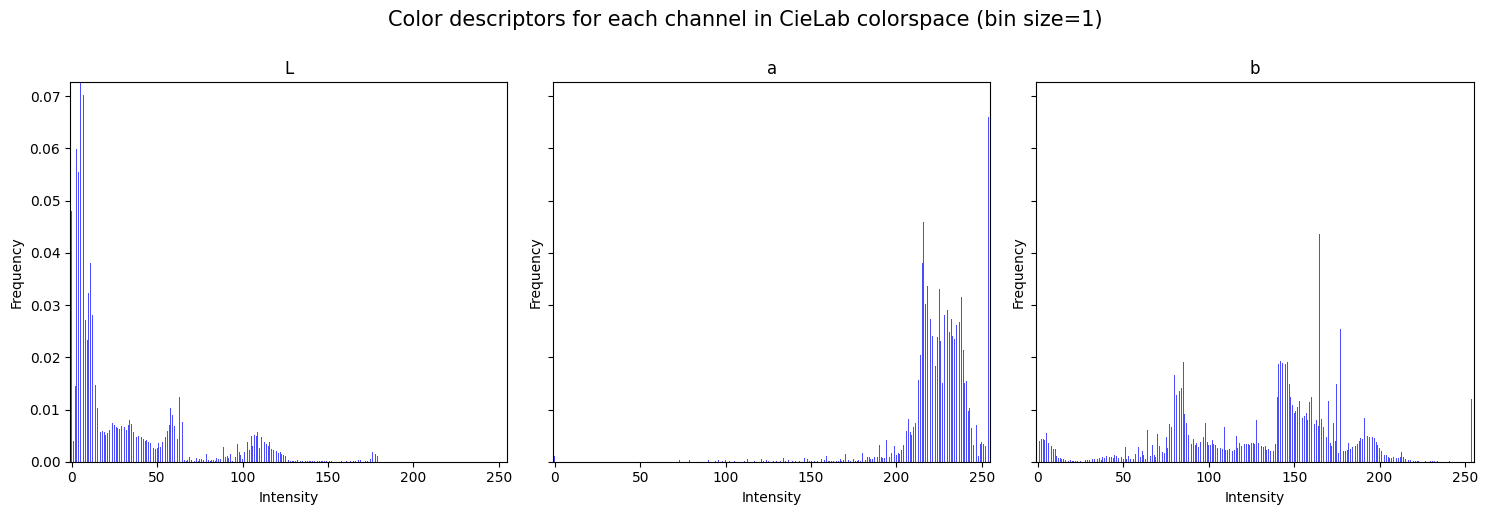

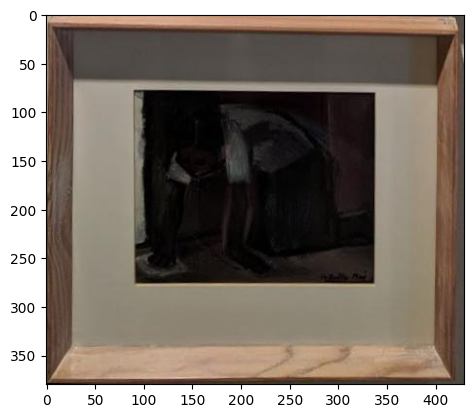

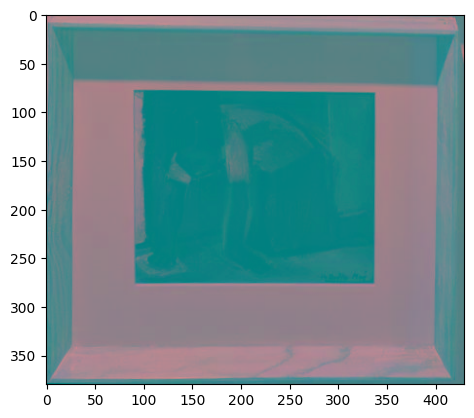

In [7]:
# Plot descriptor (histogram of each color channel) for the first image of the Query dataset. Colorspace: HSV & bin interval size=1
QueryDataset.images[0].plot_histograms()
QueryDataset.images[0].show_original()
QueryDataset.images[0].show()

## Task 2

In [6]:
"""
# TASK 2: Similarity measures

Distance:
    - Euclidean distance
    - L1 distance
    - χ2

Similarity:
    - Histogram intersection (similarity)
    - Hellinger kernel (similarity)
"""

# Implementation of the distances, similarities and evaluation metrics
from src.metrics import *

## Task 3

In [ ]:
"""
# TASK 3: For each image in QSD1, compute similarities to museum images

- Return the top k images (highest score, lowest distance)
- Evaluation with mAP@K (mean Average Precision at K)

Provide mAP@k (k=1, k=5) results for the validation query set (QSD1)
"""

In [ ]:
# Return top k results
k = 5

result = [[] for _ in range(len(QueryDataset.images))]

for image in QueryDataset.images:
    distances_list = []
    for image2 in BDDataset.images:
        distances = image.compute_distance(image2, type=DistanceType.l1)
        distance = np.mean(distances) # We can play with min, max, sum ...
        distances_list.append(distance)
    top_k = np.argsort(distances_list)[:k]

    result[image.index] = [BDDataset.images[i].index for i in top_k]

In [7]:
# Load ground truth correspondences
with open(f'{DATA_DIRECTORY}/qsd1_w1/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

# Compute mAP@K for k=1 and k=5
mapk(ground_truth, result, k=k)

0.46888888888888897

In [24]:
"""
Let's verify that the distance from the query image to it's correspondence on the DB is lower than a randomly selected image on the DB
"""

image1 = Image(f'{DATA_DIRECTORY}/qsd1_w1/00000.jpg', colorspace=ColorSpace.HSV) # Query (first img of the QSD1)

image1_bbdd = Image(f'{DATA_DIRECTORY}/BBDD/bbdd_00120.jpg', colorspace=ColorSpace.HSV) # BBDD (same img than image1)
rand_image_bbdd = Image(f'{DATA_DIRECTORY}/BBDD/bbdd_00229.jpg', colorspace=ColorSpace.HSV) # BBDD (random img from BBDD)


print(
f'Distance(img1, img1_bbdd): {np.mean(image1.compute_distance(image1_bbdd, type=DistanceType.l1))} \n'
f'Distance(img1, rand_img_bbdd): {np.mean(image1.compute_distance(rand_image_bbdd, type=DistanceType.l1))} \n\n'

'Distance from image1 to it\'s correspondence from BBDD is lower than to a randomly selected image in BBDD. \n'
'Things are working as expected :)'
)

Distance(img1, img1_bbdd): 0.5206865071937165 
Distance(img1, rand_img_bbdd): 0.8166156570173898 

Distance from image1 to it's correspondence from BBDD is lower than to a randomly selected image in BBDD. 
Things are working as expected :)


## Task 3.5: Find top-2 methods

In [ ]:
""" 
Before submiting the results for testing with QST1, let's find the methods that work better.
We will try to optimize mAP@K with the parameters: 
   - Colorspace of the image 
   - bin_size of the hitograms 
   - Metric to compute differences between descriptors (distance or similarity).
   - Handling of the three distances (one for each channel) before computing mAP@K: Mean, min, max, sum...
"""



## Task 4

In [ ]:
""" 
# TASK 4: Submit your results for a “blind” competition in QST1

Format: For each test query in QST1, a list of the K=10 best results:
    - Create a python list of lists, with the image ids (integer numbers)
    - Example with 3 queries and K=2
        Query: [[q1], [q2], [q3]]
        Result: [[7,2], [76, 4], [43, 12]]
    Where 7 corresponds to image 00007.jpg, etc.
"""

# For loop

In [174]:
from typing import Dict
import numpy as np
from src.metrics import DistanceType, SimilarityType, apk

def compute_results_by_distance(
      bdd_dataset: ImageDataset,
      query_dataset: ImageDataset,
      result_dict: Dict,
      key: str,
      ground_truth: List[List[int]],
      distance_type: DistanceType = DistanceType.l1
   ) -> Dict:

   result = []
   distances_result = []
   
   for image in query_dataset.images:
      distances_list = []
      
      for image2 in bdd_dataset.images:
         # Compute distance between two images
         image_distances = image.compute_distance(image2, type=distance_type)
         avg_distance = np.mean(image_distances)
         distances_list.append(avg_distance)
      
      # Get top 5 closest images based on distance (smaller is closer)
      top_k = np.argsort(distances_list)[:5]
      
      # Store the results for this query image
      result.append([bdd_dataset.images[i] for i in top_k])
      distances_result.append([distances_list[i] for i in top_k])
   
   # Calculate the average precision at k (apk) for k=1 and k=5
   apk1 = [apk(a, p, 1) for a, p in zip(ground_truth, result)]
   apk5 = [apk(a, p, 5) for a, p in zip(ground_truth, result)]
   
   # Update the result dictionary
   result_dict[key] = {
      'apk1': apk1,
      'apk5': apk5,
      'distances': distances_result
   }

   return result_dict


def compute_results_by_similarity(
      bdd_dataset: ImageDataset,
      query_dataset: ImageDataset,
      result_dict: Dict,
      key: str,
      similarity: SimilarityType = SimilarityType.l1
   ) -> Dict:

   result = []
   similarities_result = []
   for image in query_dataset.images:
      similarities_list = []
      for image2 in bdd_dataset.images:
         similarities = image.compute_similarities(image2, type=similarity)
         similarity = np.mean(similarities)
         similarities_list.append(similarities)
      top_k = np.argsort(similarities_list)[:5]

      result.append([bdd_dataset.images[i] for i in top_k])
      similarities_result.append([similarities_list[i] for i in top_k])
   
   result_dict[key] = {
      'apk1': [apk(a,p,1) for a,p in zip(ground_truth, result)],
      'apk5': [apk(a,p,5) for a,p in zip(ground_truth, result)],
      'similarities': similarities_result
   }

   return result_dict

SyntaxError: ':' expected after dictionary key (1638870523.py, line 49)

In [173]:
from typing import Dict
from src.metrics import DistanceType, apk
import numpy as np

BBDD_PATH = f'{DATA_DIRECTORY}/BBDD'
QUERY_PATH = f'{DATA_DIRECTORY}/qsd1_w1'

# Load ground truth correspondences
with open(f'{DATA_DIRECTORY}/qsd1_w1/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)


result_dict = {}

for colorspace in ColorSpace:
   print('Processing for colorspace:', colorspace.name)
   bdd_dataset = ImageDataset(BBDD_PATH, colorspace=colorspace)
   query_dataset = ImageDataset(QUERY_PATH, colorspace=colorspace)

   result_dict = compute_results_by_distance(bdd_dataset, query_dataset, result_dict, key=colorspace._name_)
   

Processing for colorspace: gray


AttributeError: 'NoneType' object has no attribute 'image'

In [16]:
np.mean(result_dict['CieLab']['apk5'])

np.float64(0.42888888888888893)

In [36]:
intervals = [7, 12]

result_dict_intervals = {}

for interval in intervals:
    bdd_dataset = ImageDataset(BBDD_PATH, colorspace=ColorSpace.CieLab, interval=interval)
    query_dataset = ImageDataset(QUERY_PATH, colorspace=ColorSpace.CieLab, interval=interval)

    result_dict_intervals = compute_results(bdd_dataset, query_dataset, result_dict_intervals, key=interval)

In [100]:
bdd_dataset = ImageDataset(BBDD_PATH, colorspace=ColorSpace.CieLab, interval=7)
query_dataset = ImageDataset(QUERY_PATH, colorspace=ColorSpace.CieLab, interval=7)

In [167]:
result = {}
result = compute_results(bdd_dataset, query_dataset, result, key=0)

In [168]:
np.mean(result[0]['apk5'])

np.float64(0.41388888888888886)

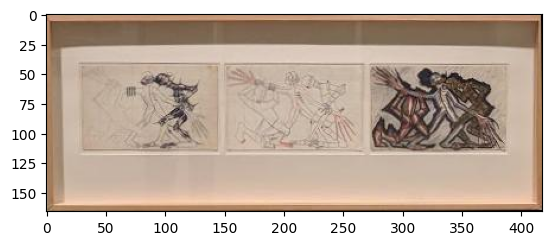

In [137]:
query_dataset.images[5].show_original()

In [138]:
image = query_dataset.images[5]

distances_list = []
for image2 in bdd_dataset.images:
    distances = image.compute_distance(image2, type=DistanceType.l1)
    distance = np.mean(distances) # We can play with min, max, sum ...
    distances_list.append(distance)
top_k = np.argsort(distances_list)[:5]

result = [bdd_dataset.images[i].index for i in top_k]

In [147]:
result

[278, 186, 191, 20, 182]

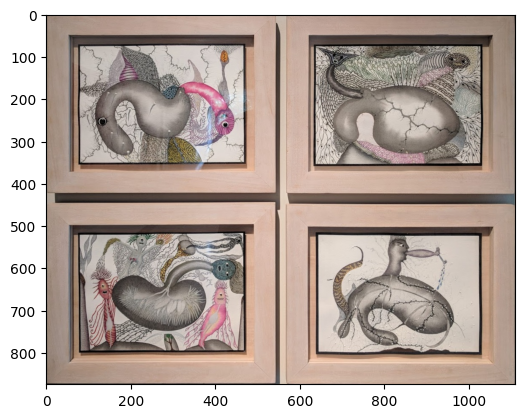

In [148]:
for image in bdd_dataset.images:
    if image.index == 278:
        image.show_original()

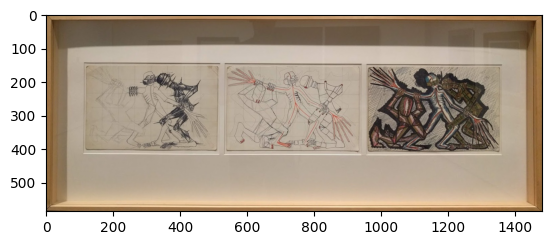

In [149]:
for image in bdd_dataset.images:
    if image.index == 182:
        image.show_original()

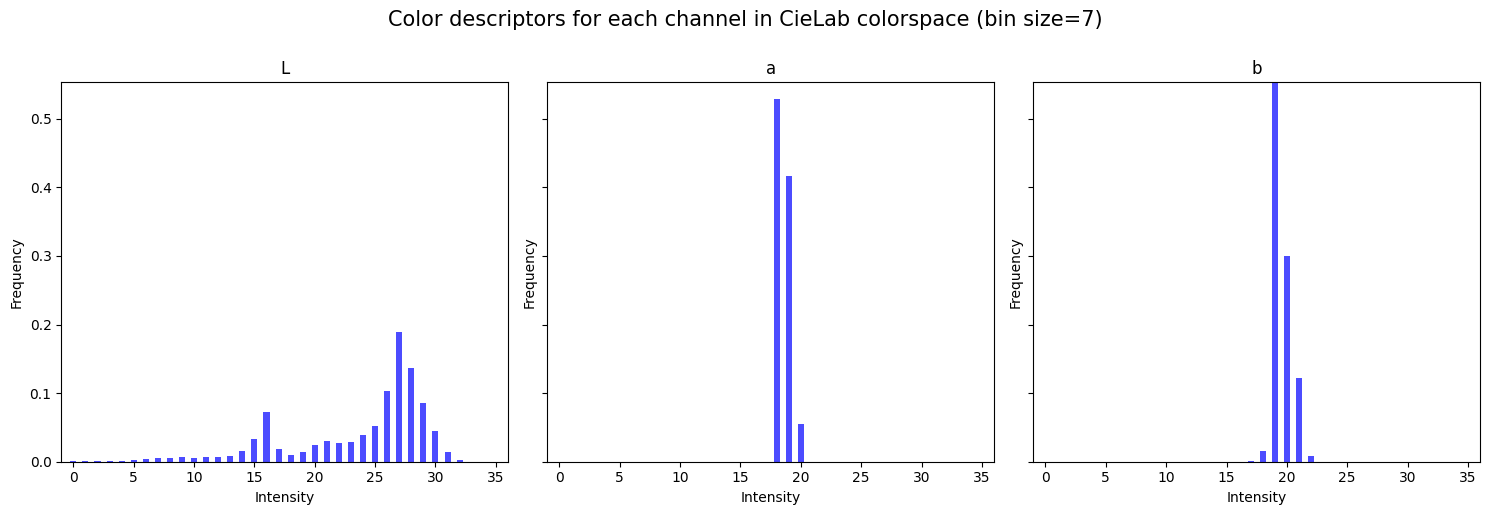

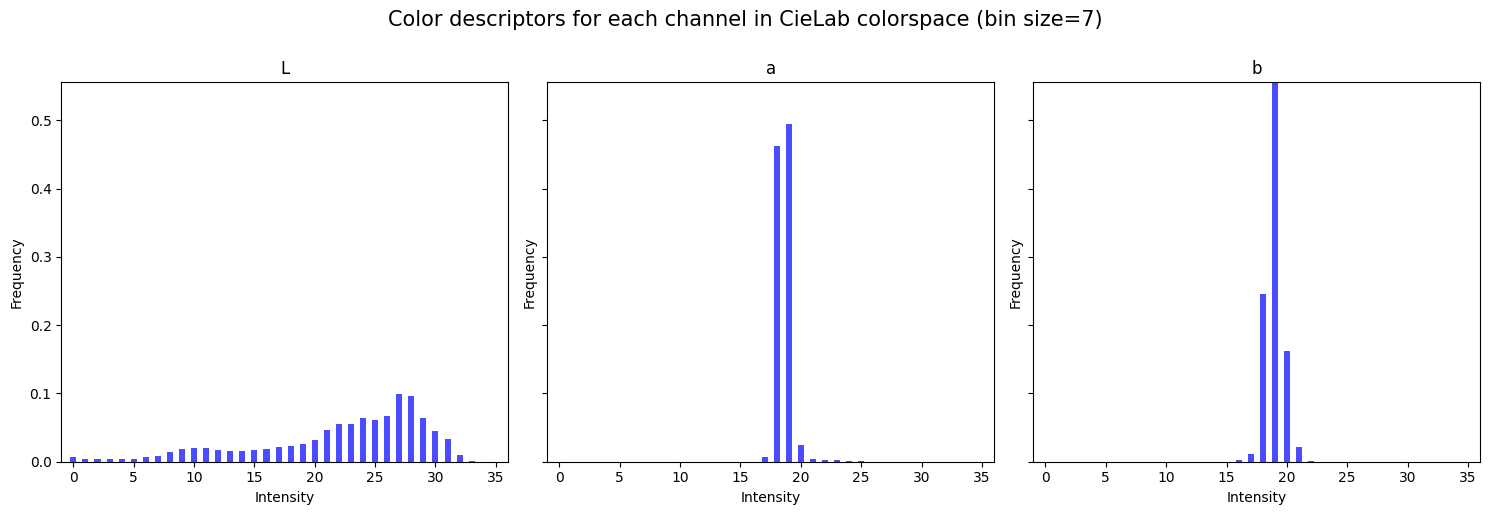

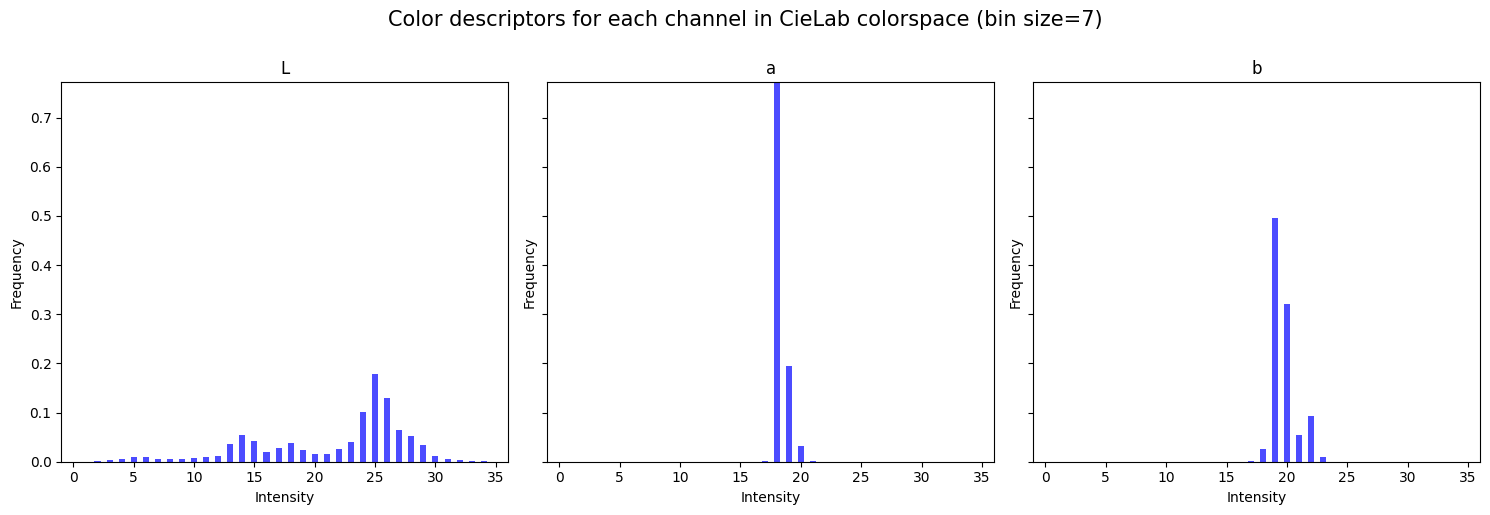

In [152]:
query_dataset.images[5].plot_histograms()
for image in bdd_dataset.images:
    if image.index == 278:
        image.plot_histograms()
for image in bdd_dataset.images:
    if image.index == 182:
        image.plot_histograms()